In [1]:
import random
import numpy as np
import igraph as ig
import scipy as sp 
import networkx as nx
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics.cluster import normalized_mutual_info_score, rand_score,adjusted_rand_score


import scipy.linalg

import rpy2
from rpy2.robjects.packages import importr, data
import rpy2.robjects as ro
from rpy2.robjects import numpy2ri

from SpectralMethod import *

import warnings
warnings.filterwarnings('ignore')

import os
os.environ['PYTHONWARNINGS']='ignore'

%load_ext rpy2.ipython


# Testing Robustness of Coarse Graining Methods

Test if CG methods are robust to the removal of random nodes using clustering metrics to compare the original coarse graining to the subsquent ones to node removal.

# Random removal of nodes

In [2]:
num_nodes = 1000
rem_nodes = 100
g = ig.Graph.Erdos_Renyi(num_nodes, 0.1)
A = g.get_adjacency_sparse().todense()
np.savetxt('./data/adj_0.txt',A)

In [3]:
def remove_n_nodes(adj_mat, n_removed):
    removed_nodes_index = []
    if n_removed > adj_mat.shape[0]:
        print('not enough nodes!')
    nodes_labels = np.arange(adj_mat.shape[0])
    np.random.shuffle(nodes_labels)
    for i in range(n_removed):
        new_adj_mat = np.delete(adj_mat, nodes_labels[:i], axis=0)
        new_adj_mat = np.delete(new_adj_mat, nodes_labels[:i], axis=1)
        np.savetxt(f'./data/adj_{i+1}.txt',new_adj_mat)
    np.savetxt(f'./data/removed_nodes.txt',nodes_labels)

In [4]:
remove_n_nodes(A,rem_nodes)

In [5]:
import joblib
joblib.Parallel(n_jobs=10)(joblib.delayed(spectral_save)(np.loadtxt(f'./data/adj_{rem}.txt'), f'./results/spectral/spectral_{rem}.txt') for rem in range(rem_nodes));

In [6]:
%%R
library('igraph')
source('SuperNode.R')
setwd('/Users/Cande007/Library/CloudStorage/OneDrive-UniversiteitUtrecht/Documents/Conferences/2023_Zaragoza_Collabathon')

super_nodes <- 5
rem_nodes <- 100
rem_nodes <- rem_nodes-1
for (i in 0:rem_nodes){
    data <- as.matrix(read.table(paste0("./data/adj_",i,".txt")))
    network <- graph_from_adjacency_matrix(data, mode = c( "undirected"))
    #let's try 500 super nodes: plese feel free to change as you wish!
    SNOut=SuperNode(network, super_nodes)
    Node2SN=array(SNOut$SNAssn)
    write.table(SNOut$SNAssn, paste0("./results/supernode/supernodes_",i,".txt"), row.names = FALSE, col.names = FALSE)

}


In [ ]:
removed_nodes_index = [int(x) for x in np.loadtxt(f'./data/removed_nodes.txt')]

spectral_results = [np.loadtxt(f'./results/spectral/spectral_{i}.txt') for i in range(rem_nodes)]
supernode_results = [np.loadtxt(f'./results/supernode/supernodes_{i}.txt') for i in range(rem_nodes)]

In [ ]:
nmi_spectral = [normalized_mutual_info_score(np.delete(spectral_results[1], removed_nodes_index[:j+1]), spectral_results[j+2]) for j in range(rem_nodes-3)]
RI_spectral = [rand_score(np.delete(spectral_results[1], removed_nodes_index[:j+1]), spectral_results[j+2]) for j in range(rem_nodes-3)]
ARI_spectral = [adjusted_rand_score(np.delete(spectral_results[1], removed_nodes_index[:j+1]), spectral_results[j+2]) for j in range(rem_nodes-3)]

nmi_sn = [normalized_mutual_info_score(np.delete(supernode_results[1], removed_nodes_index[:j+1]), supernode_results[j+2]) for j in range(rem_nodes-3)]
RI_sn = [rand_score(np.delete(supernode_results[1], removed_nodes_index[:j+1]), supernode_results[j+2]) for j in range(rem_nodes-3)]
ARI_sn = [adjusted_rand_score(np.delete(supernode_results[1], removed_nodes_index[:j+1]), supernode_results[j+2]) for j in range(rem_nodes-3)]

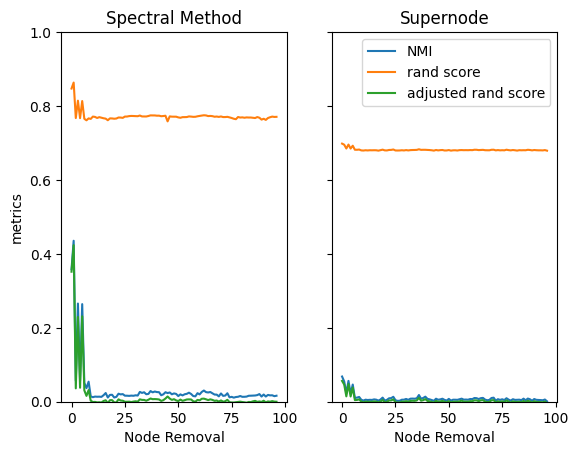

In [ ]:
from matplotlib import pyplot as plt

fig , (ax1, ax2) = plt.subplots(1,2, sharex=True, sharey=True)

from matplotlib import pyplot as plt

ax1.plot(nmi_spectral, label = 'NMI')
ax1.plot(RI_spectral, label = 'rand score')
ax1.plot(ARI_spectral, label = 'adjusted rand score')
ax1.set_ylabel('metrics')
ax1.set_xlabel('Node Removal')
ax1.set_title('Spectral Method')
ax1.set_ylim(0,1)


ax2.plot(nmi_sn, label = 'NMI')
ax2.plot(RI_sn, label = 'rand score')
ax2.plot(ARI_sn, label = 'adjusted rand score')

ax2.set_title('Supernode')
#ax2.set_ylabel('metrics')
ax2.set_xlabel('Node Removal')
plt.legend()
plt.show()